In [620]:
import tensorflow as tf
from tensorflow import keras
from keras import datasets, layers, models, Sequential
import numpy as np
import matplotlib.pyplot as plt
from keras.applications import vgg16
from turtle import shape
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import PIL

In [621]:
data_dir = 'TrainMarc'


img_height = 360
img_width = 360
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1140 files belonging to 4 classes.
Using 912 files for training.
Found 1140 files belonging to 4 classes.
Using 228 files for validation.


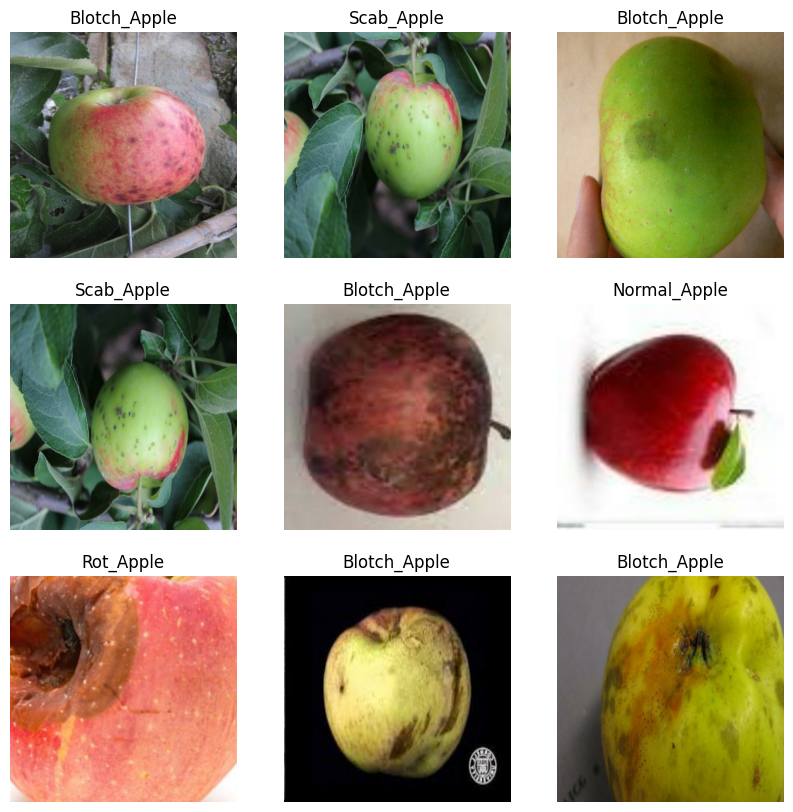

In [622]:
class_names = train_ds.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

    # plt.show()


In [634]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 360, 360, 3)
(32,)


In [635]:

data_augmentation = keras.Sequential(
  [ 
    layers.RandomFlip("horizontal_and_vertical",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(45),
    layers.RandomZoom(.4),
  ]
)


In [636]:
images = tf.cast(tf.expand_dims(images, 0), tf.float32)

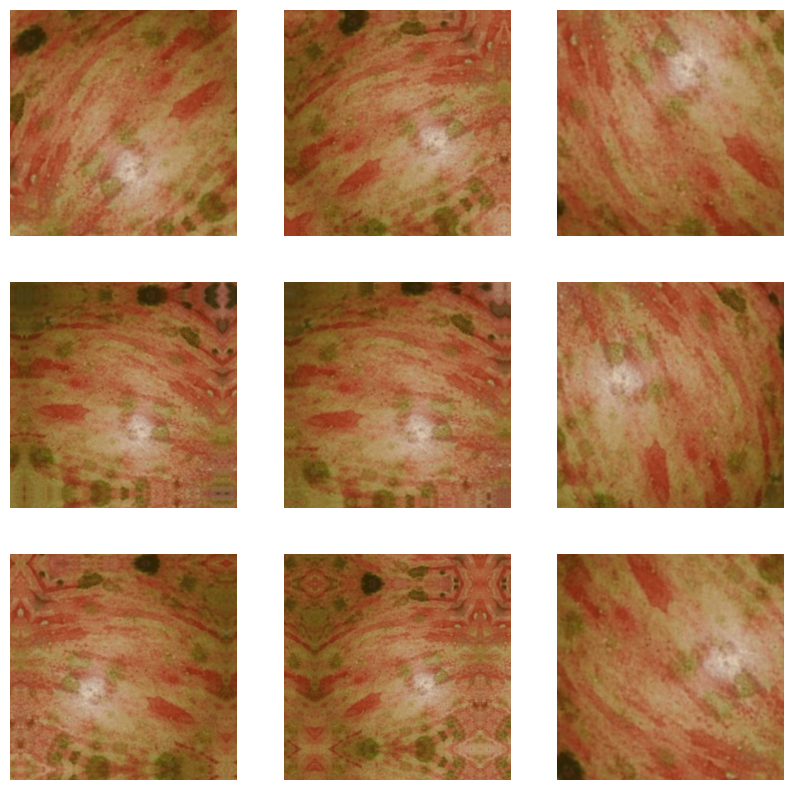

In [638]:
plt.figure(figsize=(10, 10))

image, label = next(iter(train_ds))

for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(image,training=True)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


In [627]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets.
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets.
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

In [633]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
#Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [639]:
"""
model = keras.models.Sequential()

model.add(layers.Input(shape=(360, 360, 3)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))

model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='softmax'))

model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))

model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())

model.add(layers.Dropout(0.2))

model.add(layers.Dense(4, activation='relu'))

model.summary()

num_classes = len(class_names)

"""
num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(1./255, input_shape=(360, 360, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.1),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(4),
    layers.Dense(num_classes),
    ])

model.summary()

""""
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(360,360,3)),
    tf.keras.layers.Conv2D(16, 3, padding= 'same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(16, 3, padding= 'same', activation='softmax'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(16, 3, padding= 'same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(4),
    ])

model.summary()

"""


Model: "sequential_122"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_66 (Rescaling)    (None, 360, 360, 3)       0         
                                                                 
 conv2d_249 (Conv2D)         (None, 360, 360, 16)      448       
                                                                 
 max_pooling2d_249 (MaxPooli  (None, 180, 180, 16)     0         
 ng2D)                                                           
                                                                 
 conv2d_250 (Conv2D)         (None, 180, 180, 32)      4640      
                                                                 
 max_pooling2d_250 (MaxPooli  (None, 90, 90, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_251 (Conv2D)         (None, 90, 90, 64)     

'"\nmodel = tf.keras.models.Sequential([\n    tf.keras.layers.Input(shape=(360,360,3)),\n    tf.keras.layers.Conv2D(16, 3, padding= \'same\', activation=\'relu\'),\n    tf.keras.layers.MaxPooling2D(2, 2),\n    tf.keras.layers.Conv2D(16, 3, padding= \'same\', activation=\'softmax\'),\n    tf.keras.layers.MaxPooling2D(2, 2),\n    tf.keras.layers.Conv2D(16, 3, padding= \'same\', activation=\'relu\'),\n    tf.keras.layers.MaxPooling2D(2, 2),\n    tf.keras.layers.Flatten(),\n    tf.keras.layers.Dropout(0.1),\n    tf.keras.layers.Dense(4),\n    ])\n\nmodel.summary()\n\n'

In [640]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [641]:
epochs=15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
29/29 [==============================] - 29s 980ms/step - loss: 1.3248 - accuracy: 0.3673 - val_loss: 1.2242 - val_accuracy: 0.4605
Epoch 2/15
29/29 [==============================] - 33s 1s/step - loss: 1.1786 - accuracy: 0.5241 - val_loss: 1.1630 - val_accuracy: 0.4781
Epoch 3/15
29/29 [==============================] - 34s 1s/step - loss: 1.0648 - accuracy: 0.5713 - val_loss: 1.1088 - val_accuracy: 0.5658
Epoch 4/15
29/29 [==============================] - 33s 1s/step - loss: 0.9523 - accuracy: 0.6173 - val_loss: 1.0185 - val_accuracy: 0.5614
Epoch 5/15
29/29 [==============================] - 33s 1s/step - loss: 0.8615 - accuracy: 0.6601 - val_loss: 0.9818 - val_accuracy: 0.6096
Epoch 6/15
29/29 [==============================] - 33s 1s/step - loss: 0.7275 - accuracy: 0.7281 - val_loss: 0.8746 - val_accuracy: 0.6491
Epoch 7/15
29/29 [==============================] - 33s 1s/step - loss: 0.6476 - accuracy: 0.7588 - val_loss: 0.9060 - val_accuracy: 0.6447
Epoch 8/15
29/29 

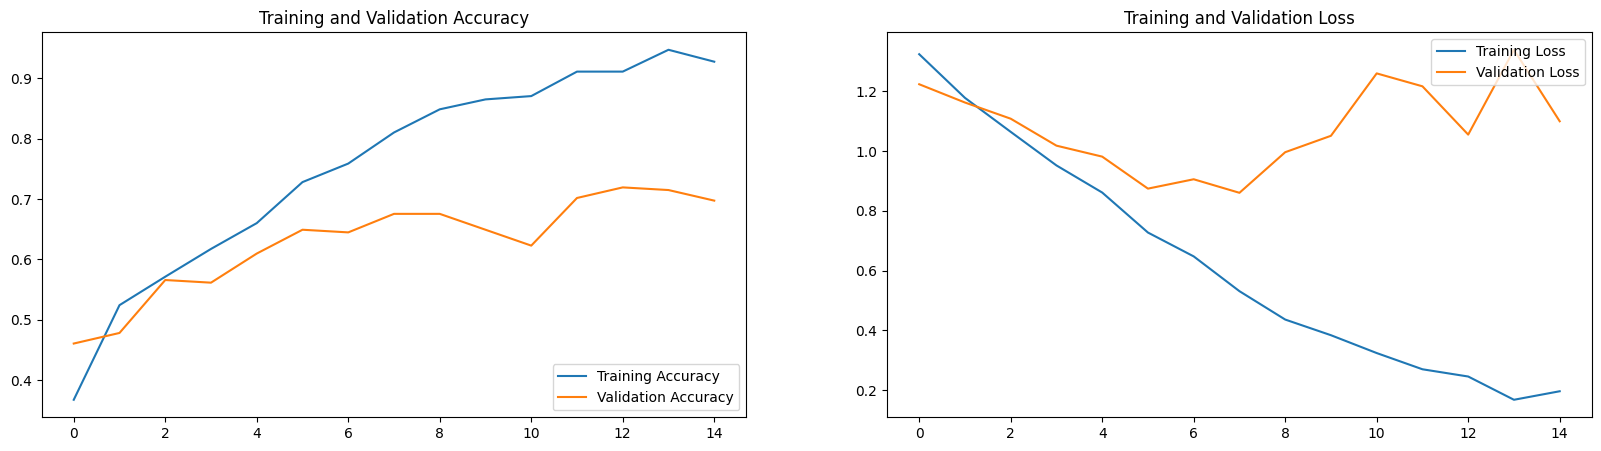

In [642]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

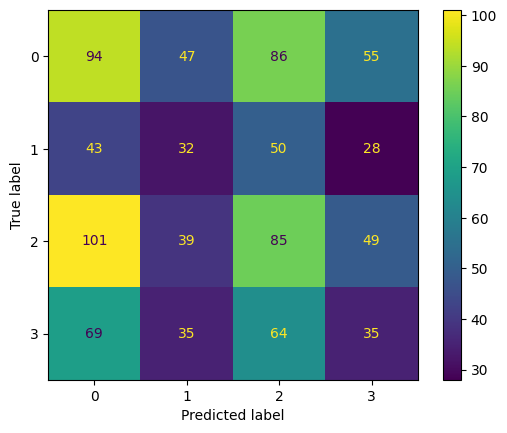

In [643]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

batchPredictions = model.predict(train_ds)

predicted_categories = tf.argmax(batchPredictions, axis=1)

true_categories = tf.concat([y for x, y in train_ds], axis=0)

# confusion_matrix(predicted_categories, true_categories)

confusion_matrix = confusion_matrix(true_categories, predicted_categories)

cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

cm_display.plot()

plt.show()